In [1]:
# transformer_testing.py
import os, sys, json
import joblib
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score
from matplotlib.ticker import FuncFormatter, MultipleLocator
import logging
import matplotlib.pyplot as plt

import sys
PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
SRC_DIR = str(Path(PROJECT_DIR) / "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from datetime import datetime
from config.settings_hpc import *

logging.basicConfig(level=logging.INFO, format='%(message)s')

# ---------------------------------------------------------------------
# Paths / config
# ---------------------------------------------------------------------


from multiomic_transformer.models.model import MultiomicTransformer
from multiomic_transformer.datasets.dataset import MultiChromosomeDataset, SimpleScaler, fit_simple_scalers

experiment = "256_4_layers"
SELECTED_EXPERIMENT_DIR = OUTPUT_DIR / "all_chroms_model_size_testing" / experiment
gpu_log_file = Path(PROJECT_DIR) / "LOGS" / "transformer_logs" / "03_training" / "gpu_usage_transformer_training_3409891.20251107_155906.csv"

GROUND_TRUTH_DIR = os.path.join(PROJECT_DIR, "data/ground_truth_files")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH  = 32
TG_CHUNK = 64

/gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /lib64/libc.so.6: version `GLIBC_2.32' not found (required by /gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/torch_scatter/_version_cuda.so)
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/gpfs/Home/esm5360/.conda/envs/my_env/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stac

TypeError: unsupported operand type(s) for |: 'type' and 'NoneType'

In [39]:
data_dfs = []
data_dir = "data/processed/mESC_no_scale_linear"
for sample in SAMPLE_NAMES:
    sample_dir = os.path.join(data_dir, sample)
    file = os.path.join(sample_dir, "tf_tg_data.parquet")
    if os.path.isfile(file):
        data_dfs.append(pd.read_parquet(file))
total_tf_tg_data = pd.concat(data_dfs)
total_tf_tg_data.head()
        
    

,TF,TG,reg_potential,motif_density,mean_tf_expr,mean_tg_expr,expr_product,log_reg_pot,motif_present,label,...,string_database_score,string_textmining_score,string_combined_score,trrust_sign,trrust_regulation,trrust_pmids,trrust_support_n,kegg_signal,kegg_n_pathways,kegg_pathways
0,RORB,TAMALIN,0.0,0.000000,0.009337,0.012840,0.000120,0.0,0,0,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None
1,ZFP711,RAB39,0.0,0.000000,0.045856,0.012976,0.000595,0.0,0,0,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None
2,TRP73,CYYR1,0.0,0.693147,0.008034,0.045602,0.000366,0.0,1,0,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None
3,HHEX,CPED1,0.0,1.098612,0.017146,0.016809,0.000288,0.0,1,0,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None
4,ZEB1,GM16126,0.0,0.000000,0.075492,0.004535,0.000342,0.0,0,0,...,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    accuracy_score,
)
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# =========================
# 1) Build pseudo-labeled set
# =========================

# --- Load embeddings & vocab ---
emb = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_embeddings.pt", map_location="cpu")
tf_emb = emb["tf_emb"]   # [T, D]
tg_emb = emb["tg_emb"]   # [G, D]

id2name = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt", map_location="cpu")
tf_id2name = id2name["tf_id2name"]
tg_id2name = id2name["tg_id2name"]

tf_name2id = {n: i for i, n in enumerate(tf_id2name)}
tg_name2id = {n: i for i, n in enumerate(tg_id2name)}

tf_norm = torch.nn.functional.normalize(tf_emb, p=2, dim=1)
tg_norm = torch.nn.functional.normalize(tg_emb, p=2, dim=1)

# --- Load prior TF-TG scores ---
df_all = total_tf_tg_data

# Keep only pairs that exist in embedding vocab
mask = df_all["TF"].isin(tf_name2id) & df_all["TG"].isin(tg_name2id)
df_all = df_all[mask].copy()

# Map to indices
df_all["tf_id"] = df_all["TF"].map(tf_name2id)
df_all["tg_id"] = df_all["TG"].map(tg_name2id)

# Cosine similarity feature from embeddings
tf_vec = tf_norm[df_all["tf_id"].values]       # [N, D]
tg_vec = tg_norm[df_all["tg_id"].values]       # [N, D]
cos_sim = (tf_vec * tg_vec).sum(dim=1).numpy()
df_all["cos_sim"] = cos_sim

feat_cols = [
    "cos_sim",
    "log_reg_pot",
    "motif_density",
    "motif_present",
    "mean_tf_expr",
    "mean_tg_expr",
    "expr_product",
]

df_all = df_all.copy()
for c in feat_cols:
    df_all[c] = pd.to_numeric(df_all[c], errors="coerce").fillna(0.0)

X_all = df_all[feat_cols].values.astype("float32")
N_all = X_all.shape[0]
print(f"Total candidate pairs (universe): {N_all}")

# ---------- 1. Build stricter pseudo-labels ----------

# Use stricter highs/lows
hi_logreg = df_all["log_reg_pot"].quantile(0.95)
hi_cos    = df_all["cos_sim"].quantile(0.95)
hi_expr   = df_all["expr_product"].quantile(0.95)

lo_logreg = df_all["log_reg_pot"].quantile(0.10)
lo_cos    = df_all["cos_sim"].quantile(0.10)
lo_expr   = df_all["expr_product"].quantile(0.25)

# Strong positives:
#   motif present
#   AND (high log_reg OR high cos)
#   AND high-ish expr product
pos_mask = (
    (df_all["motif_present"] == 1) &
    ((df_all["log_reg_pot"] >= hi_logreg) |
     (df_all["cos_sim"]     >= hi_cos)) &
    (df_all["expr_product"] >= hi_expr)
)

# Candidate negatives:
#   no motif
#   AND all signals low
neg_strict_mask = (
    (df_all["motif_present"] == 0) &
    (df_all["log_reg_pot"] <= lo_logreg) &
    (df_all["cos_sim"]     <= lo_cos) &
    (df_all["expr_product"]<= lo_expr)
)

pos_df = df_all[pos_mask].copy()
neg_candidates = df_all[neg_strict_mask].copy()

print(f"Strict positives: {len(pos_df)}, strict neg candidates: {len(neg_candidates)}")

if len(pos_df) == 0 or len(neg_candidates) == 0:
    raise RuntimeError("No strong pos or neg with current thresholds; adjust them.")

# Sample negatives to get ~1:3 pos:neg (tunable)
rng = np.random.default_rng(42)
pos_n = len(pos_df)
neg_target = min(len(neg_candidates), pos_n * 3)
neg_df = neg_candidates.sample(neg_target, random_state=42)

# Build pseudo-labeled set
pseudo_df = pd.concat([pos_df.assign(label=1.0),
                       neg_df.assign(label=0.0)],
                      axis=0)
pseudo_df = pseudo_df.sample(frac=1.0, random_state=42)

X_pseudo = pseudo_df[feat_cols].values.astype("float32")
y_pseudo = pseudo_df["label"].values.astype("float32")

N = X_pseudo.shape[0]
print(
    f"Pseudo-labeled training set size: {N} "
    f"(pos={int(y_pseudo.sum())}, neg={N-int(y_pseudo.sum())}, "
    f"pos_frac={y_pseudo.mean():.3f})"
)

# ---------- 2. Train/val split ----------
idx = np.arange(N)
rng.shuffle(idx)

train_frac = 0.8
n_train = int(train_frac * N)
train_idx = idx[:n_train]
val_idx   = idx[n_train:]

def make_loader(X, y, idxs, batch_size=2048, shuffle=False):
    X_t = torch.from_numpy(X[idxs]).float()
    y_t = torch.from_numpy(y[idxs]).float()
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_pseudo, y_pseudo, train_idx, shuffle=True)
val_loader   = make_loader(X_pseudo, y_pseudo, val_idx,   shuffle=False)

# ---------- 3. Model ----------
model = nn.Sequential(
    nn.Linear(len(feat_cols), 64),
    nn.ReLU(),
    nn.Linear(64, 1),
).to(device)

# Optional: weight positives down if still dominant
pos_frac = y_pseudo.mean()
neg_frac = 1.0 - pos_frac
# weight positives inversely to their frequency
pos_weight = torch.tensor(neg_frac / max(pos_frac, 1e-6), device=device)
bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val = float("inf")
best_state = None
EPOCHS = 15

for epoch in range(EPOCHS):
    # train
    model.train()
    train_loss_sum, n_seen = 0.0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb).squeeze(-1)
        loss = bce(logits, yb)
        loss.backward()
        opt.step()
        bs = xb.size(0)
        train_loss_sum += float(loss) * bs
        n_seen += bs
    train_loss = train_loss_sum / max(1, n_seen)

    # val
    model.eval()
    val_loss_sum, n_seen = 0.0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb).squeeze(-1)
            loss = bce(logits, yb)
            bs = xb.size(0)
            val_loss_sum += float(loss) * bs
            n_seen += bs
    val_loss = val_loss_sum / max(1, n_seen)

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch+1:02d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

if best_state is not None:
    model.load_state_dict(best_state)
model.to(device)
model.eval()

# ---------- 4. Score ALL pairs ----------
with torch.no_grad():
    logits_all = model(torch.from_numpy(X_all).float().to(device)).squeeze(-1)
    scores_all = torch.sigmoid(logits_all).cpu().numpy()

df_all["score_model"] = scores_all

# ---------- 5. Evaluate vs ChIP (same as before) ----------
chip_path = "data/ground_truth_files/mESC_beeline_ChIP-seq.csv"
chip_df = pd.read_csv(chip_path)

chip_pairs = set(zip(chip_df["Gene1"], chip_df["Gene2"]))
is_gt = np.fromiter(
    ((tf, tg) in chip_pairs for tf, tg in zip(df_all["TF"], df_all["TG"])),
    dtype=bool,
    count=len(df_all),
)
df_all["is_gt"] = is_gt

gt_total = int(is_gt.sum())
universe = len(df_all)
overall_frac = gt_total / max(universe, 1)
print("\n=== ChIP eval on full universe (all TFs) ===")
print(f"Total pairs: {universe}")
print(f"GT pairs:    {gt_total}")
print(f"GT fraction: {overall_frac:.6f}")

def enrichment_by_quantiles(scores, labels, quantiles=(0.9, 0.95, 0.99, 0.995)):
    scores = np.asarray(scores)
    labels = np.asarray(labels).astype(bool)
    rows = []
    for q in quantiles:
        thr = np.quantile(scores, q)
        top = scores >= thr
        bot = ~top
        if top.sum() == 0 or bot.sum() == 0:
            continue
        top_frac = labels[top].mean()
        bot_frac = labels[bot].mean()
        fold = (top_frac / bot_frac) if bot_frac > 0 else np.nan
        rows.append(dict(
            quantile=q,
            threshold=thr,
            top_n=int(top.sum()),
            top_gt_frac=top_frac,
            bottom_n=int(bot.sum()),
            bottom_gt_frac=bot_frac,
            enrichment_fold=fold,
        ))
    return pd.DataFrame(rows)

if gt_total > 0:
    scores = df_all["score_model"].values
    labels = df_all["is_gt"].values

    enrich = enrichment_by_quantiles(scores, labels)
    print("\n[All TFs] GT enrichment in high-score pairs vs rest:")
    print(enrich.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

    gt_scores = scores[labels]
    non_scores = scores[~labels]
    if len(gt_scores) > 0 and len(non_scores) > 0:
        u, p = mannwhitneyu(gt_scores, non_scores, alternative="greater")
        print(f"\n[All TFs] Mann–Whitney (GT > non-GT): "
              f"p={p:.3e}, GT mean={gt_scores.mean():.4f}, non-GT mean={non_scores.mean():.4f}")

    auroc = roc_auc_score(labels, scores)
    aupr  = average_precision_score(labels, scores)
    print(f"[All TFs] AUROC={auroc:.4f}, AUPR={aupr:.4f}")

# ChIP TFs only
chip_tfs = set(chip_df["Gene1"].unique())
sub = df_all[df_all["TF"].isin(chip_tfs)].copy()
scores_c = sub["score_model"].values
labels_c = sub["is_gt"].values
gt_c = int(labels_c.sum())
univ_c = len(sub)
frac_c = gt_c / max(univ_c, 1)

print("\n=== ChIP eval (ChIP TFs only) ===")
print(f"Pairs with TF in ChIP set: {univ_c}")
print(f"GT pairs in this subset:   {gt_c}")
print(f"GT fraction:               {frac_c:.6f}")

if gt_c > 0:
    enrich_c = enrichment_by_quantiles(scores_c, labels_c)
    print("\n[ChIP TFs only] GT enrichment in high-score pairs vs rest:")
    print(enrich_c.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

    gt_scores_c = scores_c[labels_c]
    non_scores_c = scores_c[~labels_c]
    if len(gt_scores_c) > 0 and len(non_scores_c) > 0:
        u, p = mannwhitneyu(gt_scores_c, non_scores_c, alternative="greater")
        print(f"\n[ChIP TFs only] Mann–Whitney (GT > non-GT): "
              f"p={p:.3e}, GT mean={gt_scores_c.mean():.4f}, non-GT mean={non_scores_c.mean():.4f}")

    auroc_c = roc_auc_score(labels_c, scores_c)
    aupr_c  = average_precision_score(labels_c, scores_c)
    print(f"[ChIP TFs only] AUROC={auroc_c:.4f}, AUPR={aupr_c:.4f}")

Total candidate pairs (universe): 597760
Strict positives: 18804, strict neg candidates: 7056
Pseudo-labeled training set size: 25860 (pos=18804, neg=7056, pos_frac=0.727)
Epoch 01: train_loss=0.3912, val_loss=0.3793
Epoch 02: train_loss=0.3649, val_loss=0.3549
Epoch 03: train_loss=0.3410, val_loss=0.3322
Epoch 04: train_loss=0.3184, val_loss=0.3102
Epoch 05: train_loss=0.2965, val_loss=0.2882
Epoch 06: train_loss=0.2746, val_loss=0.2663
Epoch 07: train_loss=0.2528, val_loss=0.2444
Epoch 08: train_loss=0.2312, val_loss=0.2227
Epoch 09: train_loss=0.2100, val_loss=0.2016
Epoch 10: train_loss=0.1894, val_loss=0.1813
Epoch 11: train_loss=0.1698, val_loss=0.1621
Epoch 12: train_loss=0.1515, val_loss=0.1443
Epoch 13: train_loss=0.1346, val_loss=0.1281
Epoch 14: train_loss=0.1194, val_loss=0.1136
Epoch 15: train_loss=0.1058, val_loss=0.1007

=== ChIP eval on full universe (all TFs) ===
Total pairs: 597760
GT pairs:    11423
GT fraction: 0.019110

[All TFs] GT enrichment in high-score pairs v

In [15]:
# Base features
all_feat_cols = [
    "cos_sim",
    "log_reg_pot",
    "motif_density",
    "motif_present",
    "mean_tf_expr",
    "mean_tg_expr",
    "expr_product",
]

# Define ablation sets
feature_sets = {
    "cos_only":          ["cos_sim"],
    "motif_only":        ["motif_present", "motif_density"],
    "regpot_only":       ["log_reg_pot"],
    "expr_only":         ["mean_tf_expr", "mean_tg_expr", "expr_product"],
    "cos+motif":         ["cos_sim", "motif_present", "motif_density"],
    "cos+regpot":        ["cos_sim", "log_reg_pot"],
    "cos+motif+regpot":  ["cos_sim", "motif_present", "motif_density", "log_reg_pot"],
    "cos+all_expr":      ["cos_sim", "mean_tf_expr", "mean_tg_expr", "expr_product"],
    "no_cos":            [c for c in all_feat_cols if c != "cos_sim"],
    "all_feats":         all_feat_cols,
}

def build_pseudo_dataset(df, pos_mask, neg_mask):
    """Use your strict masks to build (X, y) for training."""
    pos = df[pos_mask].copy()
    neg = df[neg_mask].copy()
    # use all strict pos/negs (no balancing, preserve your 0.727 pos_frac)
    pos["y"] = 1.0
    neg["y"] = 0.0
    train_df = pd.concat([pos, neg], axis=0)
    return train_df


def make_loader(X, y, batch_size=1024, shuffle=False):
    X_t = torch.from_numpy(X).float()
    y_t = torch.from_numpy(y).float()
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)


def train_small_mlp(X, y, n_epochs=15, hidden=64, lr=1e-3, val_frac=0.15, seed=0):
    """Train a tiny MLP on pseudo-labels, return trained model."""
    N, D = X.shape
    rng = np.random.default_rng(seed)
    idx = np.arange(N)
    rng.shuffle(idx)

    n_val = int(val_frac * N)
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val,   y_val   = X[val_idx],   y[val_idx]

    train_loader = make_loader(X_train, y_train, shuffle=True)
    val_loader   = make_loader(X_val,   y_val,   shuffle=False)

    model = nn.Sequential(
        nn.Linear(D, hidden),
        nn.ReLU(),
        nn.Linear(hidden, 1),
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    best_val = float("inf")
    best_state = None

    for epoch in range(1, n_epochs + 1):
        # train
        model.train()
        tr_sum, tr_n = 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb).squeeze(-1)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            bs = xb.size(0)
            tr_sum += float(loss) * bs
            tr_n += bs
        tr_loss = tr_sum / max(tr_n, 1)

        # val
        model.eval()
        va_sum, va_n = 0.0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb).squeeze(-1)
                loss = loss_fn(logits, yb)
                bs = xb.size(0)
                va_sum += float(loss) * bs
                va_n += bs
        va_loss = va_sum / max(va_n, 1)

        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    model.to(device)
    model.eval()
    return model


def enrichment_by_quantiles(scores, labels, quantiles=(0.9, 0.95, 0.99, 0.995)):
    scores = np.asarray(scores)
    labels = np.asarray(labels).astype(bool)
    rows = []
    for q in quantiles:
        thr = np.quantile(scores, q)
        top = scores >= thr
        bot = ~top
        if top.sum() == 0 or bot.sum() == 0:
            continue
        top_frac = labels[top].mean()
        bot_frac = labels[bot].mean()
        fold = (top_frac / bot_frac) if bot_frac > 0 else np.nan
        rows.append(dict(
            quantile=q,
            threshold=thr,
            top_n=int(top.sum()),
            top_gt_frac=top_frac,
            bottom_n=int(bot.sum()),
            bottom_gt_frac=bot_frac,
            enrichment_fold=fold,
        ))
    return pd.DataFrame(rows)

def eval_against_chip(model, df, chip_df, feat_cols):
    """
    Evaluate a trained model on the FULL df vs ChIP edges.
    Returns dict of summary metrics.
    """
    # Build full feature matrix
    X_all = df[feat_cols].astype("float32").to_numpy()
    X_all_t = torch.from_numpy(X_all).float().to(device)

    with torch.no_grad():
        logits = model(X_all_t).squeeze(-1)
        probs = torch.sigmoid(logits).cpu().numpy()

    # Ground truth labels from ChIP
    chip_pairs = set(zip(chip_df["Gene1"], chip_df["Gene2"]))
    is_gt = np.fromiter(
        ((tf, tg) in chip_pairs for tf, tg in zip(df["TF"], df["TG"])),
        dtype=bool,
        count=len(df),
    )

    if is_gt.sum() == 0:
        return {
            "gt_total": 0,
            "auroc_all": np.nan,
            "aupr_all": np.nan,
            "mw_p_all": np.nan,
        }

    # overall
    auroc_all = roc_auc_score(is_gt, probs)
    aupr_all = average_precision_score(is_gt, probs)

    gt_scores = probs[is_gt]
    non_scores = probs[~is_gt]
    u, p = mannwhitneyu(gt_scores, non_scores, alternative="greater")

    enrich = enrichment_by_quantiles(probs, is_gt)

    return {
        "gt_total": int(is_gt.sum()),
        "auroc_all": float(auroc_all),
        "aupr_all": float(aupr_all),
        "mw_p_all": float(p),
        "gt_mean": float(gt_scores.mean()),
        "non_mean": float(non_scores.mean()),
        "enrich_table": enrich,
    }

# --- Load embeddings & vocab ---
emb = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_embeddings.pt", map_location="cpu")
tf_emb = emb["tf_emb"]   # [T, D]
tg_emb = emb["tg_emb"]   # [G, D]

id2name = torch.load(SELECTED_EXPERIMENT_DIR / "tf_tg_vocab_id2name.pt", map_location="cpu")
tf_id2name = id2name["tf_id2name"]
tg_id2name = id2name["tg_id2name"]

tf_name2id = {n: i for i, n in enumerate(tf_id2name)}
tg_name2id = {n: i for i, n in enumerate(tg_id2name)}

tf_norm = torch.nn.functional.normalize(tf_emb, p=2, dim=1)
tg_norm = torch.nn.functional.normalize(tg_emb, p=2, dim=1)

# --- Load prior TF-TG scores ---
df_all = pd.read_parquet("data/processed/mESC_no_scale_linear/E7.5_rep1/tf_tg_data.parquet")

# Keep only pairs that exist in embedding vocab
mask = df_all["TF"].isin(tf_name2id) & df_all["TG"].isin(tg_name2id)
df_all = df_all[mask].copy()

# Map to indices
df_all["tf_id"] = df_all["TF"].map(tf_name2id)
df_all["tg_id"] = df_all["TG"].map(tg_name2id)

# Cosine similarity feature from embeddings
tf_vec = tf_norm[df_all["tf_id"].values]       # [N, D]
tg_vec = tg_norm[df_all["tg_id"].values]       # [N, D]
cos_sim = (tf_vec * tg_vec).sum(dim=1).numpy()
df_all["cos_sim"] = cos_sim

# Use stricter highs/lows
hi_logreg = df_all["log_reg_pot"].quantile(0.95)
hi_cos    = df_all["cos_sim"].quantile(0.95)
hi_expr   = df_all["expr_product"].quantile(0.95)

lo_logreg = df_all["log_reg_pot"].quantile(0.10)
lo_cos    = df_all["cos_sim"].quantile(0.10)
lo_expr   = df_all["expr_product"].quantile(0.25)

# Strong positives:
#   motif present
#   AND (high log_reg OR high cos)
#   AND high-ish expr product
pos_mask_strict = (
    (df_all["motif_present"] == 1) &
    ((df_all["log_reg_pot"] >= hi_logreg) |
     (df_all["cos_sim"]     >= hi_cos)) &
    (df_all["expr_product"] >= hi_expr)
)

# Candidate negatives:
#   no motif
#   AND all signals low
neg_strict_mask = (
    (df_all["motif_present"] == 0) &
    (df_all["log_reg_pot"] <= lo_logreg) &
    (df_all["cos_sim"]     <= lo_cos) &
    (df_all["expr_product"]<= lo_expr)
)

# 1) Build pseudo-labeled dataset from your strict masks
train_df = build_pseudo_dataset(df_all, pos_mask_strict, neg_strict_mask)
print(f"Pseudo-labeled set: {len(train_df)} rows "
      f"(pos={int((train_df['y']==1).sum())}, neg={int((train_df['y']==0).sum())})")

results = []

for name, cols in feature_sets.items():
    # make sure columns exist
    cols = [c for c in cols if c in train_df.columns]
    if not cols:
        continue

    X = train_df[cols].astype("float32").to_numpy()
    y = train_df["y"].to_numpy().astype("float32")

    model = train_small_mlp(X, y, n_epochs=15, hidden=64, lr=1e-3)

    metrics = eval_against_chip(model, df, chip_df, cols)

    results.append({
        "feature_set": name,
        "n_features": len(cols),
        "auroc_all": metrics["auroc_all"],
        "aupr_all": metrics["aupr_all"],
        "gt_mean": metrics["gt_mean"],
        "non_mean": metrics["non_mean"],
        "mw_p_all": metrics["mw_p_all"],
    })

    print(f"\n==== {name} ({len(cols)} feats) ====")
    print(f"AUROC(all): {metrics['auroc_all']:.4f}, "
          f"AUPR(all): {metrics['aupr_all']:.4f}")
    print(f"GT mean score={metrics['gt_mean']:.4f}, "
          f"non-GT mean={metrics['non_mean']:.4f}, "
          f"Mann-Whitney p={metrics['mw_p_all']:.2e}")
    print(metrics["enrich_table"].to_string(index=False,
          float_format=lambda x: f"{x:.6f}"))

# Summary table
results_df = pd.DataFrame(results).sort_values("auroc_all", ascending=False)
print("\n\n=== Feature set ranking by AUROC (ChIP, all TFs) ===")
print(results_df.to_string(index=False,
       float_format=lambda x: f"{x:.4f}"))


Pseudo-labeled set: 25860 rows (pos=18804, neg=7056)

==== cos_only (1 feats) ====
AUROC(all): 0.5252, AUPR(all): 0.0213
GT mean score=0.7760, non-GT mean=0.7681, Mann-Whitney p=1.14e-20
 quantile  threshold  top_n  top_gt_frac  bottom_n  bottom_gt_frac  enrichment_fold
 0.900000   0.876949  59777     0.023454    537983        0.018627         1.259132
 0.950000   0.901710  29888     0.026064    567872        0.018744         1.390549
 0.990000   0.944862   5978     0.028939    591782        0.019010         1.522297
 0.995000   0.952749   2989     0.032118    594771        0.019044         1.686476

==== motif_only (2 feats) ====
AUROC(all): 0.5732, AUPR(all): 0.0232
GT mean score=0.7055, non-GT mean=0.5832, Mann-Whitney p=1.29e-175
 quantile  threshold  top_n  top_gt_frac  bottom_n  bottom_gt_frac  enrichment_fold
 0.900000   0.994067  65968     0.026119    531792        0.018240         1.431931
 0.950000   0.995863  33418     0.026902    564342        0.018648         1.442583
 0.9

In [40]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import mannwhitneyu


# ============================================================
# 1. Load embeddings, vocab, and TF–TG feature table
# ============================================================

EXP_DIR = Path(SELECTED_EXPERIMENT_DIR)

emb = torch.load(EXP_DIR / "tf_tg_embeddings.pt", map_location="cpu")
tf_emb = emb["tf_emb"]   # [T, D]
tg_emb = emb["tg_emb"]   # [G, D]

id2name = torch.load(EXP_DIR / "tf_tg_vocab_id2name.pt", map_location="cpu")
tf_id2name = id2name["tf_id2name"]
tg_id2name = id2name["tg_id2name"]

tf_name2id = {n: i for i, n in enumerate(tf_id2name)}
tg_name2id = {n: i for i, n in enumerate(tg_id2name)}

tf_norm = F.normalize(tf_emb, p=2, dim=1)
tg_norm = F.normalize(tg_emb, p=2, dim=1)

df = total_tf_tg_data

mask = df["TF"].isin(tf_name2id) & df["TG"].isin(tg_name2id)
df = df[mask].copy().reset_index(drop=True)

df["tf_id"] = df["TF"].map(tf_name2id)
df["tg_id"] = df["TG"].map(tg_name2id)

tf_vec = tf_norm[df["tf_id"].values]
tg_vec = tg_norm[df["tg_id"].values]
df["cos_sim"] = (tf_vec * tg_vec).sum(dim=1).numpy()

for c in [
    "log_reg_pot",
    "motif_density",
    "motif_present",
    "mean_tf_expr",
    "mean_tg_expr",
    "expr_product",
    "cos_sim",
]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)
    else:
        df[c] = 0.0

# ============================================================
# 2. Feature set & STRICT pseudo-labels (balanced)
# ============================================================

feat_cols = [
    "cos_sim",
    "motif_present",
    "motif_density",
    "mean_tf_expr",
    "mean_tg_expr",
    "expr_product",
]

X_all = df[feat_cols].values.astype("float32")
N = len(df)

motif_present = (df["motif_present"] == 1)

# thresholds
expr_q80 = df["expr_product"].quantile(0.80)
expr_q20 = df["expr_product"].quantile(0.20)
cos_q95  = df["cos_sim"].quantile(0.95)
cos_q10  = df["cos_sim"].quantile(0.10)
md_q95   = df["motif_density"].quantile(0.95)

# ----- Strict positives -----
# Motif + at least TWO strong signals (intersection patterns)
high_expr = df["expr_product"] >= expr_q80
high_cos  = df["cos_sim"]       >= cos_q95
high_md   = df["motif_density"] >= md_q95

two_strong = (
    (high_expr & high_cos) |
    (high_expr & high_md) |
    (high_cos  & high_md)
)

strict_pos = motif_present & two_strong

# ----- Strict negatives -----
# No motif, low expr, low cosine
low_expr = df["expr_product"] <= expr_q20
low_cos  = df["cos_sim"]      <= cos_q10

strict_neg = (~motif_present) & low_expr & low_cos

pos_idx = np.where(strict_pos)[0]
neg_idx = np.where(strict_neg)[0]

print(f"Total candidate pairs (universe): {N}")
print(f"Strict positives: {len(pos_idx)}, strict negatives: {len(neg_idx)}")

# remove any overlap just in case
overlap = np.intersect1d(pos_idx, neg_idx)
if len(overlap) > 0:
    neg_idx = np.setdiff1d(neg_idx, overlap)
    print(f"Removed {len(overlap)} overlapping indices from negatives.")

# Balanced sampling
rng = np.random.default_rng(42)
max_per_class = 20000  # cap to keep it lean

n_pos = min(len(pos_idx), max_per_class)
n_neg = min(len(neg_idx), max_per_class, n_pos)  # enforce balance

if n_pos == 0 or n_neg == 0:
    raise RuntimeError("No strict positives or negatives under current thresholds.")

pos_sample = rng.choice(pos_idx, size=n_pos, replace=False)
neg_sample = rng.choice(neg_idx, size=n_neg, replace=False)

train_idx = np.concatenate([pos_sample, neg_sample])
y_train = np.concatenate([
    np.ones(n_pos, dtype=np.float32),
    np.zeros(n_neg, dtype=np.float32),
])

print(
    f"Pseudo-labeled training set size: {len(train_idx)} "
    f"(pos={n_pos}, neg={n_neg}, pos_frac={y_train.mean():.3f})"
)

X_train = X_all[train_idx]

# ============================================================
# 3. Standardize & train regularized logistic regression
# ============================================================

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)

log_reg = LogisticRegression(
    penalty="l2",
    C=0.1,              # stronger regularization than default
    class_weight=None,  # already balanced
    max_iter=1000,
    solver="lbfgs",
)
log_reg.fit(X_train_z, y_train)

# ============================================================
# 4. Score all pairs (use margins as main score)
# ============================================================

X_all_z = scaler.transform(X_all)

edge_logit = log_reg.decision_function(X_all_z)  # can be negative/positive
df["edge_score_raw"] = edge_logit

# optional 0–1 scaled version for convenience (not used for AUROC)
min_l, max_l = edge_logit.min(), edge_logit.max()
if max_l > min_l:
    df["edge_score"] = (edge_logit - min_l) / (max_l - min_l)
else:
    df["edge_score"] = 0.5  # degenerate fallback
# For evaluation we will use edge_score_raw (monotonic with edge_score).

# ============================================================
# 5. Evaluate vs ChIP-seq
# ============================================================

chip_path = "data/ground_truth_files/mESC_beeline_ChIP-seq.csv"
chip_df = pd.read_csv(chip_path)

chip_pairs = set(zip(chip_df["Gene1"], chip_df["Gene2"]))
is_gt = np.fromiter(
    ((tf, tg) in chip_pairs for tf, tg in zip(df["TF"], df["TG"])),
    dtype=bool,
    count=len(df),
)
df["is_gt"] = is_gt

gt_total = int(is_gt.sum())
overall_frac = gt_total / max(N, 1)

print("\n=== ChIP eval on full universe (all TFs) ===")
print(f"Total pairs: {N}")
print(f"GT pairs:    {gt_total}")
print(f"GT fraction: {overall_frac:.6f}")


def enrichment_by_quantiles(scores, labels, quantiles=(0.9, 0.95, 0.99, 0.995)):
    scores = np.asarray(scores)
    labels = np.asarray(labels).astype(bool)
    rows = []
    for q in quantiles:
        thr = np.quantile(scores, q)
        top = scores >= thr
        bot = ~top
        if top.sum() == 0 or bot.sum() == 0:
            continue
        top_frac = labels[top].mean()
        bot_frac = labels[bot].mean()
        fold = (top_frac / bot_frac) if bot_frac > 0 else np.nan
        rows.append(dict(
            quantile=q,
            threshold=float(thr),
            top_n=int(top.sum()),
            top_gt_frac=float(top_frac),
            bottom_n=int(bot.sum()),
            bottom_gt_frac=float(bot_frac),
            enrichment_fold=float(fold),
        ))
    return pd.DataFrame(rows)


if gt_total > 0:
    scores = df["edge_score_raw"].values  # use margin
    labels = df["is_gt"].values

    enrich = enrichment_by_quantiles(scores, labels)
    print("\n[All TFs] GT enrichment in high-score pairs vs rest:")
    print(enrich.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

    gt_scores = scores[labels]
    non_scores = scores[~labels]
    u, p = mannwhitneyu(gt_scores, non_scores, alternative="greater")
    print(
        f"\n[All TFs] Mann–Whitney (GT > non-GT): "
        f"p={p:.3e}, GT mean={gt_scores.mean():.4f}, "
        f"non-GT mean={non_scores.mean():.4f}"
    )

    auroc = roc_auc_score(labels, scores)
    aupr = average_precision_score(labels, scores)
    print(f"[All TFs] AUROC={auroc:.4f}, AUPR={aupr:.4f}")
else:
    print("No ChIP edges in universe; cannot evaluate.")


# ============================================================
# 6. ChIP TFs only eval
# ============================================================

print("\n=== ChIP eval (ChIP TFs only) ===")
chip_tfs = set(chip_df["Gene1"].unique())
mask_chip_tf = df["TF"].isin(chip_tfs)
df_chip = df[mask_chip_tf].copy()

scores_c = df_chip["edge_score_raw"].values
labels_c = df_chip["is_gt"].values

gt_total_c = int(labels_c.sum())
universe_c = len(df_chip)
overall_frac_c = gt_total_c / max(universe_c, 1)

print(f"Pairs with TF in ChIP set: {universe_c}")
print(f"GT pairs in this subset:   {gt_total_c}")
print(f"GT fraction:               {overall_frac_c:.6f}")

if gt_total_c > 0:
    enrich_c = enrichment_by_quantiles(scores_c, labels_c)
    print("\n[ChIP TFs only] GT enrichment in high-score pairs vs rest:")
    print(enrich_c.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

    gt_scores_c = scores_c[labels_c]
    non_scores_c = scores_c[~labels_c]
    u, p = mannwhitneyu(gt_scores_c, non_scores_c, alternative="greater")
    print(
        f"\n[ChIP TFs only] Mann–Whitney (GT > non-GT): "
        f"p={p:.3e}, GT mean={gt_scores_c.mean():.4f}, "
        f"non-GT mean={non_scores_c.mean():.4f}"
    )

    auroc_c = roc_auc_score(labels_c, scores_c)
    aupr_c = average_precision_score(labels_c, scores_c)
    print(f"[ChIP TFs only] AUROC={auroc_c:.4f}, AUPR={aupr_c:.4f}")
else:
    print("No GT edges with ChIP TFs in this universe.")


Total candidate pairs (universe): 6149386
Strict positives: 144711, strict negatives: 54222
Pseudo-labeled training set size: 40000 (pos=20000, neg=20000, pos_frac=0.500)

=== ChIP eval on full universe (all TFs) ===
Total pairs: 6149386
GT pairs:    83961
GT fraction: 0.013654

[All TFs] GT enrichment in high-score pairs vs rest:
 quantile  threshold  top_n  top_gt_frac  bottom_n  bottom_gt_frac  enrichment_fold
 0.900000   5.849766 614939     0.026217   5534447        0.012258         2.138857
 0.950000   7.130404 307470     0.030380   5841916        0.012773         2.378432
 0.990000  10.012398  61494     0.043874   6087892        0.013348         3.286876
 0.995000  11.296568  30747     0.049728   6118639        0.013472         3.691167

[All TFs] Mann–Whitney (GT > non-GT): p=0.000e+00, GT mean=2.1138, non-GT mean=0.2672
[All TFs] AUROC=0.6120, AUPR=0.0221

=== ChIP eval (ChIP TFs only) ===
Pairs with TF in ChIP set: 430281
GT pairs in this subset:   83961
GT fraction:          

In [41]:
df.head()

,TF,TG,reg_potential,motif_density,mean_tf_expr,mean_tg_expr,expr_product,log_reg_pot,motif_present,label,...,trrust_support_n,kegg_signal,kegg_n_pathways,kegg_pathways,tf_id,tg_id,cos_sim,edge_score_raw,edge_score,is_gt
0,RORB,TAMALIN,0.0,0.000000,0.009337,0.012840,0.000120,0.0,0,0,...,NaN,NaN,NaN,None,376,5949,0.009112,-5.881791,0.099522,False
1,ZFP711,RAB39,0.0,0.000000,0.045856,0.012976,0.000595,0.0,0,0,...,NaN,NaN,NaN,None,565,4895,-0.006479,-5.671126,0.105002,False
2,TRP73,CYYR1,0.0,0.693147,0.008034,0.045602,0.000366,0.0,1,0,...,NaN,NaN,NaN,None,460,1588,0.043302,2.383744,0.314544,False
3,HHEX,CPED1,0.0,1.098612,0.017146,0.016809,0.000288,0.0,1,0,...,NaN,NaN,NaN,None,157,1445,0.043031,3.192323,0.335578,False
4,CREB5,OGFOD3,0.0,0.000000,0.008647,0.022742,0.000197,0.0,0,0,...,NaN,NaN,NaN,None,41,4230,0.035288,-5.424239,0.111425,False


In [36]:
inferred_grn = df[["TF", "TG", "edge_score"]].rename(columns={"edge_score":"Score"})

In [37]:
inferred_grn.head()

,TF,TG,Score
0,RORB,TAMALIN,0.101665
1,ZFP711,RAB39,0.108412
2,TRP73,CYYR1,0.369248
3,HHEX,CPED1,0.394507
4,CREB5,OGFOD3,0.114179


In [38]:
inferred_grn.to_csv("output/model_classifier_testing/inferred_grn.csv")

In [45]:
true_interactions = pd.read_csv("output/model_classifier_testing/mESC_inferred_grn/mESC/balanced_true_interactions.csv", index_col=0)
false_interactions = pd.read_csv("output/model_classifier_testing/mESC_inferred_grn/mESC/balanced_false_interactions.csv", index_col=0)
labeled_df = pd.concat([true_interactions, false_interactions])
labeled_df.head()

,Source,Target,Score,true_interaction,predicted_interaction
14,GATA4,XKR4,0.230416,1,0
24,KDM2B,XKR4,0.285312,1,0
27,KLF5,XKR4,0.123565,1,0
34,NANOG,XKR4,0.213566,1,0
38,OTX2,XKR4,0.244510,1,0


In [46]:
labeled_df.to_csv("output/model_classifier_testing/mESC_inferred_grn/mESC/labeled_df.csv")


=== All TFs ranking summary ===
n=6149386, positives=83961 (pos_frac=0.0137)
AUROC=0.6120, AUPR=0.0221
 top  1%: precision=0.0439 (x3.21 vs baseline)
 top  5%: precision=0.0304 (x2.23 vs baseline)
 top 10%: precision=0.0262 (x1.92 vs baseline)

[All TFs] GT enrichment by quantile:
 quantile  threshold  top_n  top_gt_frac  bottom_n  bottom_gt_frac  enrichment_fold
 0.900000   0.404710 614939     0.026217   5534447        0.012258         2.138857
 0.950000   0.438024 307470     0.030380   5841916        0.012773         2.378432
 0.990000   0.512997  61494     0.043874   6087892        0.013348         3.286876
 0.995000   0.546404  30747     0.049728   6118639        0.013472         3.691167


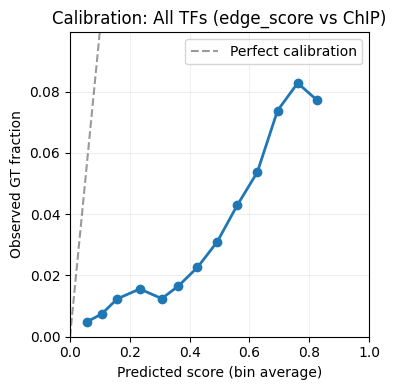


[All TFs] Confidence bins:
   bin       n  gt_frac  enrichment_vs_overall
  high   61494   0.0439                 3.2134
medium  245976   0.0270                 1.9780
   low 5841916   0.0128                 0.9355

=== ChIP TFs only ranking summary ===
n=430281, positives=83961 (pos_frac=0.1951)
AUROC=0.5695, AUPR=0.2614
 top  1%: precision=0.5021 (x2.57 vs baseline)
 top  5%: precision=0.3685 (x1.89 vs baseline)
 top 10%: precision=0.3176 (x1.63 vs baseline)

[ChIP TFs only] GT enrichment by quantile:
 quantile  threshold  top_n  top_gt_frac  bottom_n  bottom_gt_frac  enrichment_fold
 0.900000   0.414703  43029     0.317646    387252        0.181517         1.749949
 0.950000   0.447951  21515     0.368441    408766        0.186009         1.980772
 0.990000   0.526563   4303     0.501975    425978        0.192031         2.614032
 0.995000   0.561857   2152     0.560409    428129        0.193295         2.899249


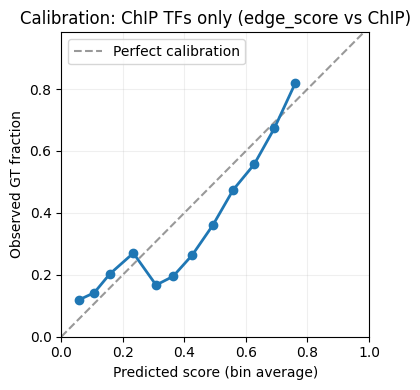


[ChIP TFs only] Confidence bins:
   bin      n  gt_frac  enrichment_vs_overall
  high   4303   0.5020                 2.5725
medium  17212   0.3351                 1.7171
   low 408766   0.1860                 0.9533


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)

# ---------------------------------------------------------
# Helpers
# ---------------------------------------------------------

def summarize_ranking(scores, labels, name="", top_fracs=(0.01, 0.05, 0.10)):
    scores = np.asarray(scores)
    labels = np.asarray(labels).astype(bool)

    baseline = labels.mean()
    auroc = roc_auc_score(labels, scores)
    aupr = average_precision_score(labels, scores)

    print(f"\n=== {name} ranking summary ===")
    print(f"n={len(scores)}, positives={labels.sum()} (pos_frac={baseline:.4f})")
    print(f"AUROC={auroc:.4f}, AUPR={aupr:.4f}")

    # precision @ top-k% (ranking use-case)
    order = np.argsort(scores)[::-1]
    for frac in top_fracs:
        k = max(1, int(len(scores) * frac))
        top = labels[order[:k]].mean() if k > 0 else np.nan
        if np.isnan(top):
            continue
        fold = top / baseline if baseline > 0 else np.nan
        print(f" top {int(frac*100):2d}%: precision={top:.4f} "
              f"(x{fold:.2f} vs baseline)")

    return dict(auroc=auroc, aupr=aupr, baseline=baseline)


def enrichment_by_quantiles(scores, labels, quantiles=(0.9, 0.95, 0.99, 0.995)):
    scores = np.asarray(scores)
    labels = np.asarray(labels).astype(bool)
    rows = []
    for q in quantiles:
        thr = np.quantile(scores, q)
        top = scores >= thr
        bot = ~top
        if top.sum() == 0 or bot.sum() == 0:
            continue
        top_frac = labels[top].mean()
        bot_frac = labels[bot].mean()
        fold = (top_frac / bot_frac) if bot_frac > 0 else np.nan
        rows.append(dict(
            quantile=q,
            threshold=thr,
            top_n=int(top.sum()),
            top_gt_frac=top_frac,
            bottom_n=int(bot.sum()),
            bottom_gt_frac=bot_frac,
            enrichment_fold=fold,
        ))
    return pd.DataFrame(rows)


def plot_reliability(scores, labels, n_bins=15, title="Calibration (reliability)"):
    scores = np.asarray(scores)
    labels = np.asarray(labels).astype(bool)

    # bin by predicted score
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx = np.digitize(scores, bins) - 1

    bin_centers = []
    pred_means = []
    obs_means = []
    counts = []

    for b in range(n_bins):
        mask = idx == b
        if mask.sum() < 50:  # require some mass
            continue
        bin_scores = scores[mask]
        bin_labels = labels[mask]
        bin_centers.append(bin_scores.mean())
        pred_means.append(bin_scores.mean())
        obs_means.append(bin_labels.mean())
        counts.append(mask.sum())

    if not bin_centers:
        print("Not enough variation for reliability curve.")
        return

    plt.figure(figsize=(4,4))
    plt.plot([0,1],[0,1],"k--",alpha=0.4,label="Perfect calibration")
    plt.plot(pred_means, obs_means, marker="o", lw=2)
    plt.xlabel("Predicted score (bin average)")
    plt.ylabel("Observed GT fraction")
    plt.title(title)
    plt.ylim(0, max(obs_means)*1.2)
    plt.xlim(0, 1)
    plt.grid(alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()


def make_confidence_table(df, score_col="edge_score", label_col="is_gt",
                          high_q=0.99, med_q=0.95):
    """High/medium/low confidence bins based on quantiles."""
    scores = df[score_col].values
    labels = df[label_col].values.astype(bool)

    h_thr = np.quantile(scores, high_q)
    m_thr = np.quantile(scores, med_q)

    def bin_label(s):
        if s >= h_thr:
            return "high"
        elif s >= m_thr:
            return "medium"
        else:
            return "low"

    bins = np.array([bin_label(s) for s in scores])
    df_out = df.copy()
    df_out["confidence_bin"] = bins

    rows = []
    for b in ["high", "medium", "low"]:
        mask = bins == b
        if mask.sum() == 0:
            continue
        frac = labels[mask].mean()
        rows.append(dict(
            bin=b,
            n=int(mask.sum()),
            gt_frac=frac,
        ))
    tbl = pd.DataFrame(rows)
    overall = labels.mean()
    tbl["enrichment_vs_overall"] = tbl["gt_frac"] / overall
    return df_out, tbl.sort_values("gt_frac", ascending=False)


# =========================================================
# 1) Evaluate: all TFs
# =========================================================

scores_all = df["edge_score"].values
labels_all = df["is_gt"].values

summary_all = summarize_ranking(scores_all, labels_all, name="All TFs")
print("\n[All TFs] GT enrichment by quantile:")
print(enrichment_by_quantiles(scores_all, labels_all).to_string(
    index=False, float_format=lambda x: f"{x:.6f}"
))

plot_reliability(scores_all, labels_all,
                 title="Calibration: All TFs (edge_score vs ChIP)")

conf_df_all, conf_tbl_all = make_confidence_table(df, "edge_score", "is_gt")
print("\n[All TFs] Confidence bins:")
print(conf_tbl_all.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# conf_df_all now has columns: TF, TG, edge_score, is_gt, confidence_bin
# You can export only high-confidence edges:
# conf_df_all[conf_df_all["confidence_bin"]=="high"][["TF","TG","edge_score"]]


# =========================================================
# 2) Evaluate: ChIP TFs only (sharper check)
# =========================================================

chip_df = pd.read_csv("data/ground_truth_files/mESC_beeline_ChIP-seq.csv")
chip_tfs = set(chip_df["Gene1"].unique())

df_chip = df[df["TF"].isin(chip_tfs)].copy()
scores_c = df_chip["edge_score"].values
labels_c = df_chip["is_gt"].values

summary_chip = summarize_ranking(scores_c, labels_c,
                                 name="ChIP TFs only")

print("\n[ChIP TFs only] GT enrichment by quantile:")
print(enrichment_by_quantiles(scores_c, labels_c).to_string(
    index=False, float_format=lambda x: f"{x:.6f}"
))

plot_reliability(scores_c, labels_c,
                 title="Calibration: ChIP TFs only (edge_score vs ChIP)")

conf_df_chip, conf_tbl_chip = make_confidence_table(df_chip,
                                                    "edge_score",
                                                    "is_gt")
print("\n[ChIP TFs only] Confidence bins:")
print(conf_tbl_chip.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Again, high-confidence candidate GRN:
# conf_df_chip[conf_df_chip["confidence_bin"]=="high"][["TF","TG","edge_score"]]


In [50]:
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import precision_recall_curve

# ============================================================
# 1. Assume df already exists with columns:
#    TF, TG, edge_score, is_gt  (is_gt from ChIP)
# ============================================================

# If needed, load from disk instead:
# df = pd.read_csv("labeled_df.csv")  # must contain the columns above

# Basic sanity checks
req_cols = {"TF", "TG", "edge_score", "is_gt"}
missing = req_cols - set(df.columns)
if missing:
    raise ValueError(f"df is missing required columns: {missing}")

df = df.copy()
df["edge_score"] = df["edge_score"].astype(float)
df["is_gt"] = df["is_gt"].astype(bool)

# ============================================================
# 2. Build calibration set (ChIP TFs only; more reliable regime)
# ============================================================

chip_tfs = set(df.loc[df["is_gt"], "TF"].unique())
cal_mask = df["TF"].isin(chip_tfs)

cal = df[cal_mask].copy()
print(f"Calibration set: n={len(cal)}, positives={cal['is_gt'].sum()}")

if cal["is_gt"].sum() < 50:
    raise RuntimeError("Too few GT positives in calibration set for reliable calibration.")

# Sort by score for isotonic regression
cal_sorted = cal.sort_values("edge_score")
x = cal_sorted["edge_score"].values
y = cal_sorted["is_gt"].values.astype(float)

# Fit monotone mapping score -> P(GT)
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(x, y)

# Attach calibrated probabilities to calibration subset
cal["p_cal"] = iso.predict(cal["edge_score"].values)

# ============================================================
# 3. Pick a probability threshold from calibration
#    Strategy: choose smallest p where precision >= target_prec
# ============================================================

def choose_threshold_from_calibration(cal_df, p_col="p_cal",
                                      target_prec=0.5,
                                      min_positives=50):
    """
    Choose a calibrated probability threshold such that
    precision(P(GT | score) >= thr) >= target_prec on calibration set.
    """
    scores = cal_df[p_col].values
    labels = cal_df["is_gt"].values.astype(int)

    # Use actual labels for precision-recall curve
    prec, rec, thr = precision_recall_curve(labels, scores)

    # precision_recall_curve returns thr for all but first point
    thr = np.concatenate(([0.0], thr))  # align lengths

    # mask thresholds that give enough positives
    # (avoid ultra-high thresholds with 3 edges)
    n_pred_pos = [(scores >= t).sum() for t in thr]
    n_pred_pos = np.array(n_pred_pos)

    ok = (prec >= target_prec) & (n_pred_pos >= min_positives)
    if not np.any(ok):
        # fallback: use percentile-based threshold (e.g. top 5%)
        q = 0.95
        backup_thr = np.quantile(scores, q)
        print(f"[WARN] No threshold hit precision>={target_prec}. "
              f"Using backup q={q:.2f} (thr={backup_thr:.3f}).")
        return float(backup_thr)

    # pick the *lowest* threshold that satisfies conditions
    best_idx = np.where(ok)[0][0]
    chosen_thr = float(thr[best_idx])

    print(f"Chosen calibrated p-threshold = {chosen_thr:.3f} "
          f"(precision={prec[best_idx]:.3f}, n_pos={n_pred_pos[best_idx]})")
    return chosen_thr

p_threshold = choose_threshold_from_calibration(
    cal,
    p_col="p_cal",
    target_prec=0.5,      # require ≥50% ChIP precision in calibration set
    min_positives=100,    # at least 100 predicted positives to be stable
)

# ============================================================
# 4. Apply calibration to ALL edges and build high-confidence GRN
# ============================================================

# Calibrated probability for all edges
df["p_edge"] = iso.predict(df["edge_score"].values)

# High-confidence edges: calibrated P(GT) >= p_threshold
hc = df[df["p_edge"] >= p_threshold].copy()

# (Optional) constrain to top-K per TF to avoid giant hubs
TOP_K_PER_TF = 500  # tune as you like

hc = (
    hc.sort_values(["TF", "p_edge"], ascending=[True, False])
      .groupby("TF", as_index=False)
      .head(TOP_K_PER_TF)
)

print(f"\nHigh-confidence network:")
print(f"  edges passing p >= {p_threshold:.3f}: {len(hc)}")
print(f"  unique TFs: {hc['TF'].nunique()}, unique TGs: {hc['TG'].nunique()}")

# Save
out_path = "output/model_classifier_testing/inferred_grn.csv"
hc = hc.rename(columns={"p_edge":"Score"})
hc[["TF", "TG", "Score"]].to_csv(
    out_path, sep=",", index=False
)
print(f"Saved calibrated high-confidence GRN to: {out_path}")


Calibration set: n=408269, positives=83961
Chosen calibrated p-threshold = 0.407 (precision=0.515, n_pos=6417)

High-confidence network:
  edges passing p >= 0.407: 43548
  unique TFs: 475, unique TGs: 996
Saved calibrated high-confidence GRN to: output/model_classifier_testing/inferred_grn.csv


In [2]:
import torch
motif_mask = torch.load("data/training_data_cache/mESC_no_scale_linear/chr1/motif_mask_chr1.pt")

In [3]:
print(motif_mask)

tensor([[     0.0000,      0.0000,      0.0000,  ...,      0.0000,
              0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,  ...,      0.0000,
              0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,  ..., -27209.9961,
         -49381.5156, -39295.1172],
        ...,
        [     0.0000,      0.0000,      0.0000,  ...,      0.0000,
         -46684.1367, -39094.7305],
        [     0.0000,      0.0000,      0.0000,  ...,      0.0000,
         -43699.2031, -38727.0508],
        [     0.0000,      0.0000,      0.0000,  ...,      0.0000,
              0.0000,      0.0000]])
